<font size=10> ENSO and drier-get-gotter </font>

<b><font color='red'>Note: the major data processing step (#9) takes a long time (likely ~8 mins), so you probably want to start running this thing before reading, and maybe turn on some netflix or something idk</font></b>

Also I'm just using the AOS573 environment, so no need to create it again

According to Byrne, 2021, using the Weak Temperature Gradient approximation, drier places should warm more than wetter places.  This is termed the "drier-get-hotter" mechanism (Byrne, 2021).  However, this relationship has been validated only in modeled datasets (as of the last time I read about this.  As Mike Byrne was my undergraduate advisor, I was able to do some research on this topic and attempt to validate the relationship using instrumental datasets.  What I did was calculated the annual change in temperatures of each tropical weather stations hottest days over time from the HadISD WMO weather station dataset (see: https://www.metoffice.gov.uk/hadobs/hadisd/), and compare to their specific humidity. The initial results were as follows: 

The figure below shows the average year-to-year percentage temperature change of the hottest 50% of days (in each year).  Each dot is an individual station's average % temperature change of the hottest days, and the average specific humidity during those days.

<img src='image/50y2y.png' />

As you can see, the proposed relationship is not visible.  Each station lies more or less along temperature change = 0, and there is no temperature change-specific humidity trend.  However, there are some major limitations of this methodology.

1: There are huge areas of time missing for many stations, and most stations have no specific humidity data before 1950, at the earliest.  This means there is not a huge amount of data to create a statistical relationship.

2: Natural variability as a result of local climate and geography is greater than the anthropogenic forcing which should result in the "drier-get-hotter" relationship.  This too limits the statistically significant signal which may be extracted from the dataset.  The data used is from individual stations, but other than selecting for being in the tropics, there is no location or geography specific treatment.  As a result, the majority of the relationship above is likely random noise.

In order to mitigate these problems, Larissa Back (my current advisor) proposed I use ENSO cycles to group temperature and specific humidity signals, as ENSO is known to change tropospheric temperatures (Chiang et al, 2005).  Rather than relying on an geography-specific temperature trend as a function of climate change with a lot of variance between stations, looking at the temperature-specific humidity relationship as a function of ENSO (as a proxy for global troposphere temperature) may result in a cleaner signal.  FOr this, I compared daily temperature-specific humidity relationships for El Nino days over time, and compared to the relationship for La Nina days.  

The results are as follows:

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
!pwd # this has to be the bowman_final_project directory because the next step reads the next level - /samplehum2 directory

pwd: ignoring non-option arguments
/tornado/home1/class/fall22/qbowman/bowman_final_project


First, I will create an xarray dataset for each of the  station's netcdf files, and fill the missing temperature values with nan

In [3]:
dshum = []
        
hstats = os.listdir('samplehum2/') # a random selection of data from 4 stations, because one of the steps takes a long time, so I cut down from ~900 and several 100 gb to 4 stations lol
for filename in hstats:
    ds = xr.open_dataset('samplehum2/' + filename)
    ds = ds.where(ds['temperatures'] != -2e+30) # masks missing values with nan
    dshum += [ds] #humidity datasets also include temperature
    
    # if (ds.latitude.values[0] > -20) and (ds.latitude.values[0] < 20): # this was an alternative step to filter for only tropical stations and remove missing ones.  No longer necessary
    #     dshum += [ds]
    # else:
    #     os.remove('samplehum/' + filename)

Next, I will read the nino3.4 ENSO anomaly dataset (see: https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/ ) to extract monthly values, while removing headers, footers, and years (as I want a single continuous monthly timeseries)

In [4]:
da = pd.read_csv('nino34.long.anom.data',sep='   ',skiprows=[0],skipfooter=8,usecols=[1,2,3,4,5,6,7,8,9,10,11,12],engine='python') # reads in the csv, removing monthly titles ( that i just added :/ ) and years
da

jan   feb   mar   apr   may   jun   jul   aug   sep   oct   nov   dec
0   -1.00 -1.20 -0.83 -0.81 -1.27 -1.08 -1.04 -0.88 -0.53 -0.92 -0.79 -0.79
1   -0.25 -0.58 -0.43 -0.50 -0.70 -0.53 -0.60 -0.33 -0.24 -0.33 -0.31 -0.58
2   -0.72 -0.62 -0.50 -0.77 -0.62 -0.52 -0.32 -0.85 -1.02 -0.94 -0.79 -0.88
3   -0.78 -1.01 -1.31 -0.67 -0.53 -0.48 -0.58 -0.39 -0.34 -0.78 -0.77 -0.70
4   -0.93 -1.06 -1.40 -0.94 -0.86 -0.72 -1.00 -1.05 -1.13 -1.25 -1.33 -1.14
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
147 -0.34 -0.01 -0.09  0.22  0.30  0.22  0.22 -0.18 -0.56 -0.52 -0.84 -0.85
148 -0.86 -0.73 -0.73 -0.36 -0.12  0.12  0.27  0.05  0.30  0.84  1.00  0.97
149  0.51  0.62  0.81  0.67  0.61  0.66  0.41  0.19  0.11  0.55  0.74  0.51
150  0.64  0.48  0.36  0.49 -0.12 -0.21 -0.04 -0.42 -0.66 -1.19 -1.01 -0.98
151 -1.04 -0.94 -0.72 -0.55 -0.41 -0.06 -0.20 -0.38 -0.50 -0.78 -0.88 -1.07

[152 rows x 12 columns]

Next, I reshape the nino3.4 dataset into a 1d single timeseries, then add a corresponding datetime time series, then turn it into an xarray datarray so I can work with the dates and values together

In [5]:
nino1d = da.to_numpy().reshape(-1) # turn to 1d horizontal numpy array of monthly el nino index from jan 1870

In [6]:
ninotime = np.arange(np.datetime64("1870-01"), np.datetime64("2022-01"), np.timedelta64(1, "M"))
ninotime # numpy 1d array of monthly datetimes for time coordinate in nino1d

array(['1870-01', '1870-02', '1870-03', ..., '2021-10', '2021-11',
       '2021-12'], dtype='datetime64[M]')

In [7]:
ninods = xr.DataArray(nino1d) #turns it to xarray so I can work with dates and enso index together
da=xr.DataArray(nino1d,coords={'time':ninotime}) # adds time coordinate
da

<xarray.DataArray (time: 1824)>
array([-1.  , -1.2 , -0.83, ..., -0.78, -0.88, -1.07])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2021-12-01

Here, I want to create a dataset which is each month that is El Nino (La Nina), as well as the strength of the index during those months.

In [8]:
# First, remove all of the data before the hadISD dataset begins, and where it is not El Nino ( La Nina )
# El Nino ( La Nina ) defined here to be where index >= 1 ( <= -1 )

nino = da.time.where(da>=1).where(da.time > np.datetime64("1930-12")).dropna(dim='time') # array of valid times, dropping the nans for faster checking in the next step.
ninomag = da.where(da>=1).where(da.time > np.datetime64("1930-12")).dropna(dim='time').values # array of El Nino strength during those times

ninoseries = [] # empty nest to be filled with valid series
ninochecks = [] # empty list ot be filled with valid El Nino dates, for easier checking in next step

for month in nino:
    ninochecks.append((month.dt.year.values, month.dt.month.values))  #creates a set of valid year, month combinations for el nino/la nina, so i can check against it faster
                                                                      # when iterating over all valid days for station data in next step
                                                                      # Saves month and year so I can compare to month and year from daily hadISD dataset
        
        
        
nina = da.time.where(da<=-1).where(da.time > np.datetime64("1930-12")).dropna(dim='time') # same as above steps, but for La Nina
ninamag = da.where(da<=-1).where(da.time > np.datetime64("1930-12")).dropna(dim='time').values

ninaseries = []
ninachecks = []

for month in nina:
    ninachecks.append((month.dt.year.values, month.dt.month.values))
    
ninoseries = (ninochecks,ninomag) # each series is tuple of 2 components.  First is a list of valid (year, month) dates for ENSO, and the second is the corresponding list of ENSO strength during that (year, month)
ninaseries = (ninachecks,ninamag) # it is formatted this way for ease of indexing and checking in the next step


As the hadISD datasets are ~6 hourly data, I need to resample to daily.  After that, each day is checked if it during a strong ENSO cycle.  If so, that day's temperature, specific humidity, and ENSO strength are all added to a dataset.  This takes a long time!

In [9]:
ninodays = []# initialized empty lists that will have daily (temperature, specific humidity, and el nino index value) saved
ninadays = []

ninochecklist = ninoseries[0] #list of valid El Nino year-month combos from earlier
ninomaglist = ninoseries[1] #list of corresponding ENSO strength

ninachecklist = ninaseries[0]
ninamaglist = ninaseries[1]

#technically my old method of just using like, lists and numpy was way faster but I guess this is less error prone and clearer huh

for station in dshum:
    ds_resampled = station.resample(time='24H').mean(dim='time')
    
    for day in ds_resampled.time:
        ds = ds_resampled.sel(time=day)
        
        month = ds.time.dt.month.values # for "checking" year, month, combo against el nino
        year = ds.time.dt.year.values
        
        check = (year,month) 
        
        if check in ninochecklist:
            ind = ninochecklist.index(check)
            ninodays.append((ds.temperatures.values,ds.specific_humidity.values,ninomaglist[ind])) # creates list of every single el nino day's (temperature, specific humidity, and el nino index value)
            
        elif check in ninachecklist:
            ind = ninachecklist.index(check)
            ninadays.append((ds.temperatures.values,ds.specific_humidity.values,ninamaglist[ind]))
            
# I tried to optimize this step for speed based off my minimal computer science knowledge because it takes a very long time
# so if it is a little unclear with usage of variables, that is why
# I tried to have as few logical loops and variable assignments and boolean checks as possible

# there may be a way to do it faster by keeping larger amounts of data in single xarray datasets instead of checking between the ENSO datasets and the resampled daily datasets

After this, the actual data is extracted into individual lists for analysis and plotting

In [10]:
ninotemps = [] # initializing lists to contain individual data for each of temp, sphum, and ENSO magnitude
ninosphums = []
ninomags = []

for day in ninodays:
    ninotemps += [day[0]]
    ninosphums += [day[1]]
    ninomags += [day[2]]
    
ninoavgtemp = np.nanmean(ninotemps)
ninoavgsphum = np.nanmean(ninosphums)

In [11]:
ninatemps = []
ninasphums = []
ninamags = []

for day in ninadays:
    ninatemps += [day[0]]
    ninasphums += [day[1]]
    ninamags += [day[2]]
    
ninaavgtemp = np.nanmean(ninatemps)
ninaavgsphum = np.nanmean(ninasphums)


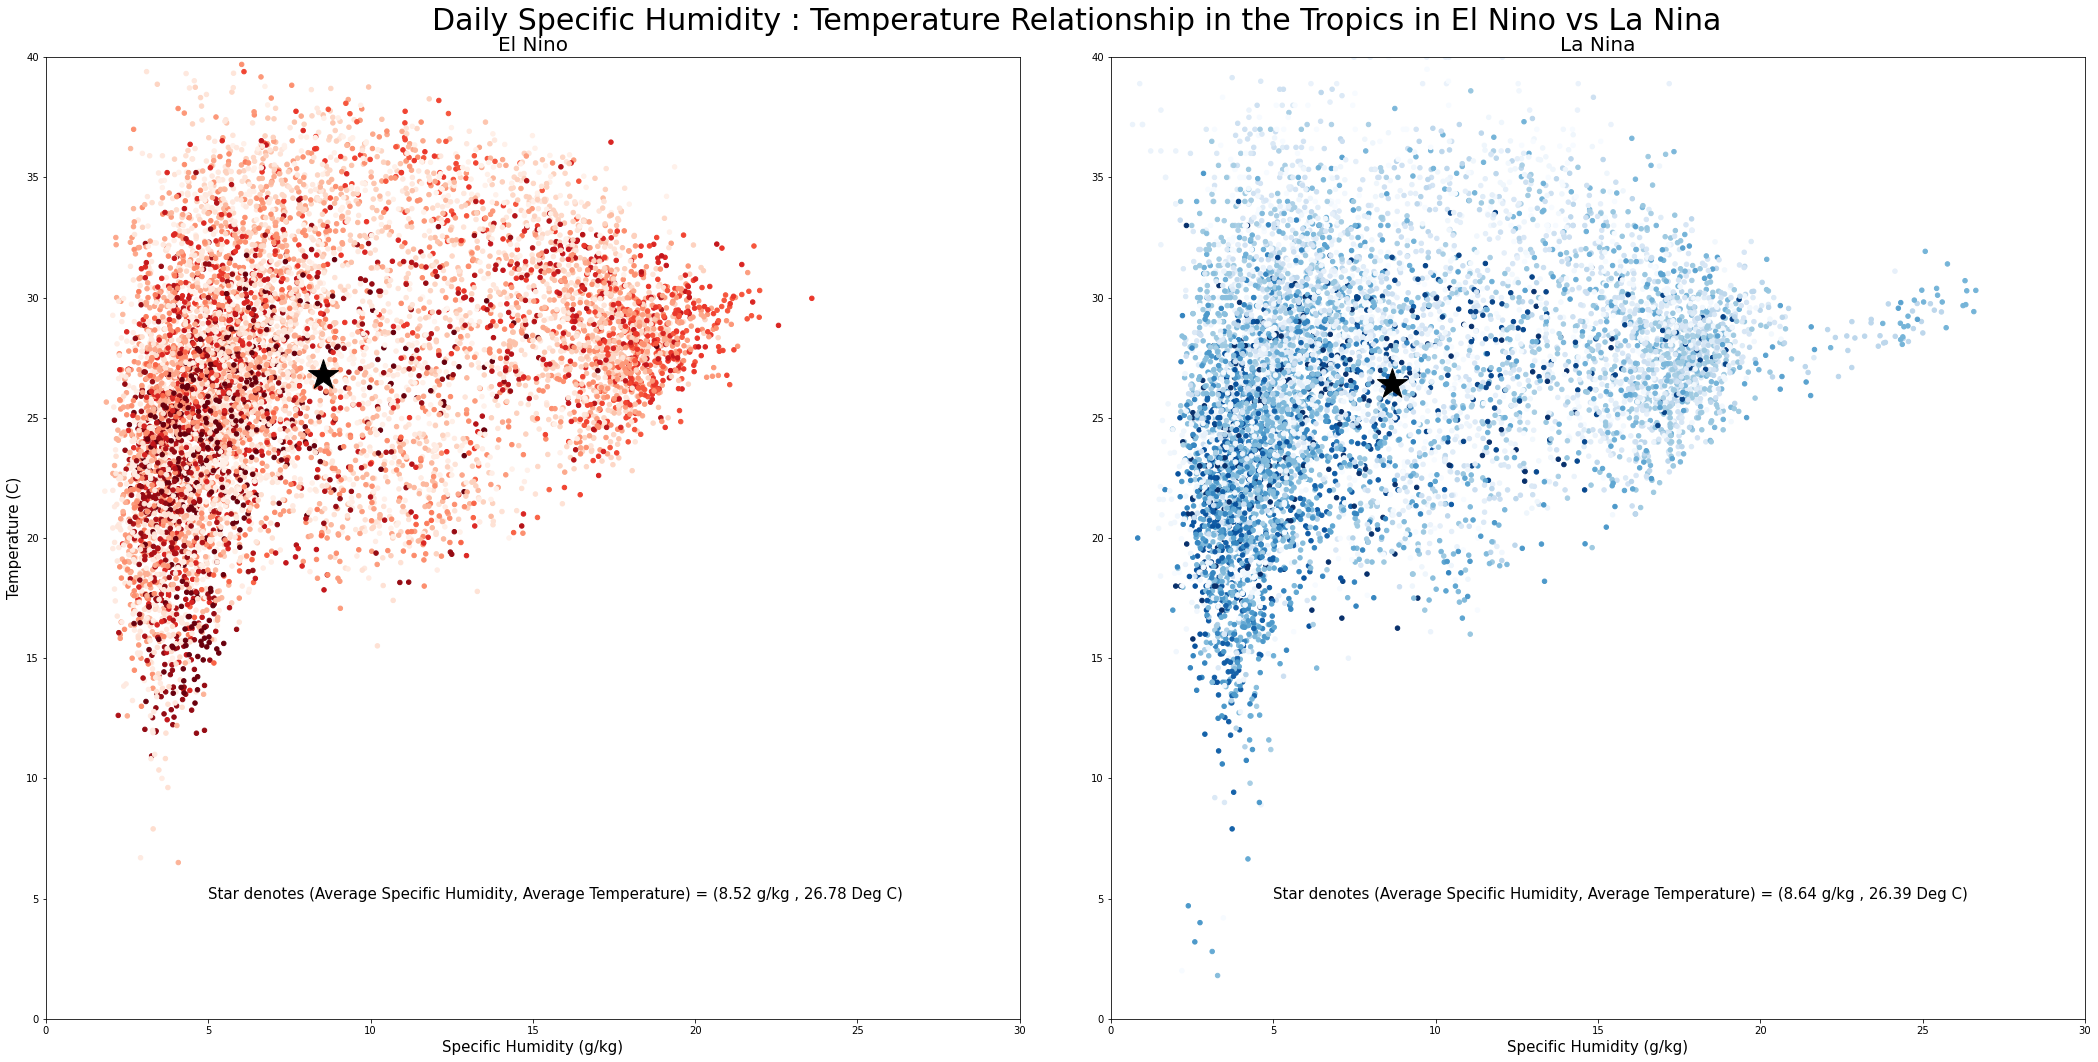

In [12]:
avgstrnino = str(ninoavgsphum)[:4]+' g/kg , '+str(ninoavgtemp)[:5]+' Deg C' # creates a singluar string (for plotting average data)
avgstrnina = str(ninaavgsphum)[:4]+' g/kg , '+str(ninaavgtemp)[:5]+' Deg C'

ninacmap = cm.Blues.reversed() # colormap for la nina is reversed in order to show absolute strength of ENSO signal

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(30,15))

ax1.scatter(ninosphums,ninotemps,c=ninomags,cmap='Reds',s=20) #scatter plots of each day in records, color coded to strength of ENSO index on that day
ax2.scatter(ninasphums,ninatemps,c=ninamags,cmap=ninacmap,s=20)

ax1.set_xlabel('Specific Humidity (g/kg)',fontsize=15)
ax2.set_xlabel('Specific Humidity (g/kg)',fontsize=15)

ax1.set_ylabel('Temperature (C)',fontsize=15)

ax1.set_ylim(0,40)
ax2.set_ylim(0,40)

ax1.set_xlim(0,30)
ax2.set_xlim(0,30)

ax1.scatter(ninoavgsphum,ninoavgtemp,c='black',marker='*',s=1000)
ax2.scatter(ninaavgsphum,ninaavgtemp,c='black',marker='*',s=1000)

ax1.text(5,5,'Star denotes (Average Specific Humidity, Average Temperature) = ('+avgstrnino+')',fontsize=15)
ax2.text(5,5,'Star denotes (Average Specific Humidity, Average Temperature) = ('+avgstrnina+')',fontsize=15)

ax1.set_title('El Nino',fontsize=20)
ax2.set_title('La Nina',fontsize=20)

plt.suptitle('Daily Specific Humidity : Temperature Relationship in the Tropics in El Nino vs La Nina',fontsize=30)

plt.tight_layout()

These are the preliminary results for this analysis.  Each dot is an individual day, color coded to ENSO strength.  The average tropical day follows roughly the same pattern whether El Nino or La Nina, but there are some differences visible.  The El NIno Index is more qualitative than quantitative here, so I have no included colorbars.

In El Nino, the average day is slighter hotter and drier than La Nina - This is an expected result in line with Byrne, 2021!

The El Nino Index is stronger on the driest days for El Nino than for La Nina.

Overall, these are promising initial results, even if there appears to be a large amount of randomness!

However, in the future I will do some better analysis.  Due to storage and time limitations, only a few station's data can be analyzed here at a time.  As there are only 4 stations, in order to get a significant amount of data on these plots, each day is plotted individually.  However, it is likely that this introduces error from the resampling process.  The stations are missing a lot of data, so days missing measurements will include temporal sampling biases.  For example, if a given day was only measured at night, it will be colder than if it had been sampled 4 times over that day's 24 hours!.  This supposed day is as equally represented as a fully measured day in the above plots.  And there is a lot of missing data!

Ideally, I would calculate one of these datasets for every station, but average each station into an average El Nino day and La Nina day, and do a similar plot to above, but each station is a dot rather than a day.  Additionally, rather than just grouping by binary ENSO strength ( ex >1, or <-1) the actual data could be correlated to the actual ENSO magnitude, perhaps in some sort of 3d plot.  I haven't decided yet.

References:

    HadISD dataset related:
Dunn, R. J. H., (2019), HadISD version 3: monthly updates, Hadley Centre Technical Note

Dunn, R. J. H., et al. (2016), Expanding HadISD: quality-controlled, sub-daily station data from 1931, Geoscientific Instrumentation, Methods and Data Systems, 5, 473-491

Dunn, R. J. H., et al. (2014), Pairwise homogeneity assessment of HadISD, Climate of the Past, 10, 1501-1522

Dunn, R. J. H., et al. (2012), HadISD: A Quality Controlled global synoptic report database for selected variables at long-term stations from 1973-2011, Climate of the Past, 8, 1649-1679

Smith, A., et al. (2011): The Integrated Surface Database: Recent Developments and Partnerships. Bulletin of the American Meteorological Society, 92, 704-708


    nino3.4 dataset related:
Rayner N. A., D. E. Parker, E. B. Horton, C. K. Folland, L. V. Alexander, D. P. Rowell, E. C. Kent, A. Kaplan, Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century, J. Geophys. Res., 108 (D14), 4407, doi:10.1029/2002JD002670, 2003.


    Theory related:
Byrne, Michael P. "Amplified warming of extreme temperatures over tropical land." Nature Geoscience 14.11 (2021): 837-841.

Chiang, John CH, and Benjamin R. Lintner. "Mechanisms of remote tropical surface warming during El Niño." Journal of climate 18.20 (2005): 4130-4149.